In [1]:
import sys
sys.path.append('/home/ybtu/FinNLP')
import json
import os
import matplotlib.pyplot as plt
from config import ROOT, RAW_DIR, FORMMATED_DIR, INDEX_DIR
import utils # utils.py
from transformers import BertTokenizer
import matplotlib.pyplot as plt

/home/ybtu/miniconda3/envs/pyserini/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 10Q

In [37]:
directory = FORMMATED_DIR

doc_count = 0
para_count = 0
total_tokens = 0
max_para_id, max_tokens = None, 0
min_para_id, min_tokens = None, float('inf')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        doc_count += 1
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                # Update
                total_tokens += num_tokens
                if num_tokens > max_tokens:
                    max_tokens = num_tokens
                    max_para_id = data['id']
                if num_tokens < min_tokens:
                    min_tokens = num_tokens
                    min_para_id = data['id']
                
                para_count += 1

print(f"Total number of documents: {doc_count}")
print(f"Total number of paragraphs: {para_count}")
print(f"Average number of tokens per paragraph: {total_tokens/para_count}")
print(f"para_id:{max_para_id}, Max number of tokens: {max_tokens}")
print(f"para_id:{min_para_id}, Min number of tokens: {min_tokens}")


Total number of documents: 30
Total number of paragraphs: 22129
Average number of tokens per paragraph: 31.780197930317684
para_id:20180502_10-Q_320193_part1_item1_para35, Max number of tokens: 1042
para_id:20200501_10-Q_320193_part1_item1_para12, Min number of tokens: 1


In [55]:
step = 100
length_groups = {}
for length in range(step, max_tokens + 1, step):
    length_groups[length] = 0
length_groups[length + 1] = 0

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                for length in length_groups:
                    if num_tokens <= length:
                        length_groups[length] += 1
                        break
                else:
                    length_groups[length] += 1


length_groups

{100: 19658,
 200: 1795,
 300: 526,
 400: 104,
 500: 27,
 600: 11,
 700: 4,
 800: 2,
 900: 0,
 1000: 1,
 1001: 1}

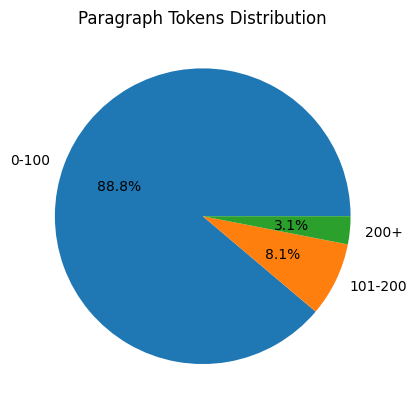

In [56]:
labels = ['0-100', '101-200', '200+']
lengths = [length_groups[100], length_groups[200], sum(length_groups.values()) - length_groups[100] - length_groups[200]]

# Plot the pie chart
plt.pie(lengths, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Paragraph Tokens Distribution')

# Display the plot
plt.show()



In [49]:
step = 10
length_groups = {}
for length in range(step, 100 + 1, step):
    length_groups[length] = 0
length_groups[length + 1] = 0

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                for length in length_groups:
                    if num_tokens <= length:
                        length_groups[length] += 1
                        break
                else:
                    length_groups[length] += 1
length_groups

{10: 14846,
 20: 1246,
 30: 655,
 40: 493,
 50: 429,
 60: 435,
 70: 434,
 80: 383,
 90: 410,
 100: 327,
 101: 2471}

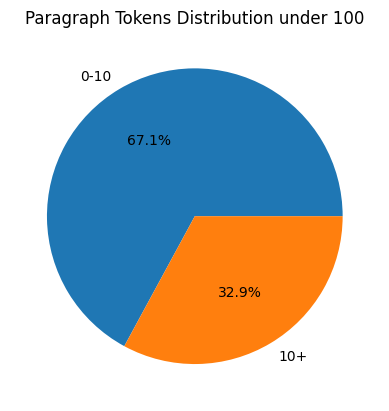

In [53]:
labels = ['0-10', '10+']
lengths = [length_groups[10], sum(length_groups.values()) - length_groups[10]]

# Plot the pie chart
plt.pie(lengths, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Paragraph Tokens Distribution under 100')

# Display the plot
plt.show()

In [21]:
def get_paragraphs_with_less_tokens(directory, n):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    para_less_than_n = []

    for filename in os.listdir(directory):
        if filename.endswith(".jsonl"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line)
                    content = data['contents']
                    tokens = tokenizer.tokenize(content)
                    num_tokens = len(tokens)

                    if num_tokens <= n:
                        para_less_than_n.append(data['id'])

    return para_less_than_n


In [28]:
min_tokens = 10
min_para_ids = get_paragraphs_with_less_tokens(FORMMATED_DIR, min_tokens)
tokens_distribution = {}
for para_id in min_para_ids:
    para = utils.retrieve_paragraph(para_id)
    tokens = tokenizer.tokenize(para)
    num_tokens = len(tokens)
    if num_tokens not in tokens_distribution:
        tokens_distribution[num_tokens] = 0
    tokens_distribution[num_tokens] += 1

tokens_distribution


{1: 3461,
 2: 2741,
 7: 495,
 4: 2901,
 5: 823,
 10: 167,
 8: 442,
 3: 3154,
 6: 440,
 9: 222}

In [35]:
sample_para = utils.retrieve_paragraph("20220426_10-Q_789019_part2_item2_para23")
tokens = tokenizer.tokenize(sample_para)
print(sample_para)
print(len(tokens))

January 1, 2022 January 31, 2022
10


In [36]:
sample_para = utils.retrieve_paragraph("20180131_10-Q_789019_part1_item2_para12")
tokens = tokenizer.tokenize(sample_para)
print(sample_para)
print(len(tokens))

LinkedIn contributed revenue of 1.3 billion.
10


# Data exploration on 10-K files

## Process data

In [2]:
# directory = "/tmp2/ybtu/FinNLP/collections/basic"
directory = FORMMATED_DIR

# Count the total number of .jsonl files
total_files = sum(1 for f in os.listdir(directory) if f.endswith(".jsonl"))
print(f"Total number of documents: {total_files}")

# Calculate the step for each 10% of the total files
progress_step = total_files // 10

doc_count = 0
para_count = 0
total_tokens = 0
max_para_id, max_tokens = None, 0
min_para_id, min_tokens = None, float('inf')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        doc_count += 1
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                # Update
                total_tokens += num_tokens
                if num_tokens > max_tokens:
                    max_tokens = num_tokens
                    max_para_id = data['id']
                if num_tokens < min_tokens:
                    min_tokens = num_tokens
                    min_para_id = data['id']
                
                para_count += 1

        # Progress reporting every 10%
        if doc_count % progress_step == 0 or doc_count == total_files:
            percent_complete = (doc_count / total_files) * 100
            print(f"Processed {doc_count}/{total_files} files ({percent_complete:.0f}%)...")

print(f"Total number of documents: {doc_count}")
print(f"Total number of paragraphs: {para_count}")
print(f"Average number of tokens per paragraph: {total_tokens/para_count}")
print(f"para_id:{max_para_id}, Max number of tokens: {max_tokens}")
print(f"para_id:{min_para_id}, Min number of tokens: {min_tokens}")

# generate length groups
step = 100
length_groups = {}
for length in range(step, max_tokens + 1, step):
    length_groups[length] = 0
length_groups[length + 1] = 0

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                for length in length_groups:
                    if num_tokens <= length:
                        length_groups[length] += 1
                        break
                else:
                    length_groups[length] += 1
    

# Create a dictionary with the results
results = {
    "Total number of documents": doc_count,
    "Total number of paragraphs": para_count,
    "Average number of tokens per paragraph": total_tokens / para_count if para_count else 0,
    "Paragraph ID with max tokens": max_para_id,
    "Max number of tokens": max_tokens,
    "Paragraph ID with min tokens": min_para_id,
    "Min number of tokens": min_tokens,
    "Length groups": length_groups
}

# Specify the file path for the JSON output
output_file_path = "data_exploration_results.json"

# Write the dictionary to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

print(f"Results saved to {output_file_path}")


Total number of documents: 30
Processed 3/30 files (10%)...
Processed 6/30 files (20%)...
Processed 9/30 files (30%)...
Processed 12/30 files (40%)...
Processed 15/30 files (50%)...
Processed 18/30 files (60%)...
Processed 21/30 files (70%)...
Processed 24/30 files (80%)...
Processed 27/30 files (90%)...
Processed 30/30 files (100%)...
Total number of documents: 30
Total number of paragraphs: 22129
Average number of tokens per paragraph: 31.780197930317684
para_id:20180502_10-Q_320193_part1_item1_para35, Max number of tokens: 1042
para_id:20200501_10-Q_320193_part1_item1_para12, Min number of tokens: 1
Results saved to data_exploration_results.json


In [ ]:
step = 100
length_groups = {}
for length in range(step, max_tokens + 1, step):
    length_groups[length] = 0
length_groups[length + 1] = 0

for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                content = data['contents']
                tokens = tokenizer.tokenize(content)
                num_tokens = len(tokens)

                for length in length_groups:
                    if num_tokens <= length:
                        length_groups[length] += 1
                        break
                else:
                    length_groups[length] += 1


length_groups

## load exploration results and plot

In [6]:
tokens_per_paragraph = None
data_exploration_results = None

with open("data_exploration_results.json", 'r') as json_file:
    data_exploration_results = json.load(json_file)

with open("tokens_per_paragraph.json", 'r') as json_file:
    tokens_per_paragraph = json.load(json_file)

tokens_per_paragraph = {key: int(value) for key, value in tokens_per_paragraph.items()}
length_groups = {int(key): value for key, value in data_exploration_results["Length groups"].items()}

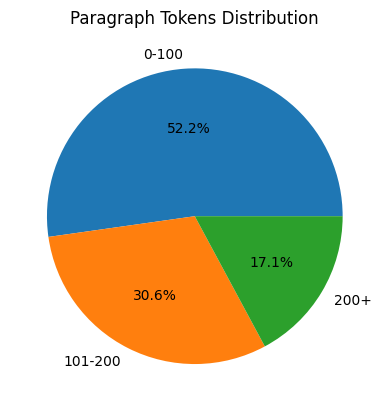

In [7]:
labels = ['0-100', '101-200', '200+']
lengths = [length_groups[100], length_groups[200], sum(length_groups.values()) - length_groups[100] - length_groups[200]]

# Plot the pie chart
plt.pie(lengths, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Paragraph Tokens Distribution')

# Display the plot
plt.show()



In [8]:
max_tokens = int(data_exploration_results['Max number of tokens'])

step = 100
length_groups = {10: 0}
for length in range(step, max_tokens + 1, step):
    length_groups[length] = 0
length_groups[max_tokens] = 0

for num_tokens in tokens_per_paragraph.values():
    if num_tokens <= 10:
        length_groups[10] += 1
    else:
        for length in length_groups:
            if num_tokens <= length:
                length_groups[length] += 1
                break
        else:
            length_groups[length] += 1

In [9]:
length_groups

{10: 59017,
 100: 829337,
 200: 520636,
 300: 177133,
 400: 59551,
 500: 24160,
 600: 12224,
 700: 6898,
 800: 4117,
 900: 2527,
 1000: 1513,
 1100: 902,
 1200: 619,
 1300: 390,
 1400: 272,
 1500: 226,
 1600: 177,
 1700: 127,
 1800: 89,
 1900: 65,
 2000: 45,
 2100: 44,
 2200: 47,
 2300: 48,
 2400: 37,
 2500: 40,
 2600: 18,
 2700: 15,
 2800: 14,
 2900: 22,
 3000: 15,
 3100: 10,
 3200: 24,
 3300: 9,
 3400: 19,
 3500: 7,
 3600: 11,
 3700: 4,
 3800: 5,
 3900: 8,
 4000: 7,
 4100: 7,
 4200: 5,
 4300: 5,
 4400: 13,
 4500: 6,
 4600: 0,
 4700: 1,
 4800: 8,
 4900: 3,
 5000: 5,
 5100: 4,
 5200: 0,
 5300: 5,
 5400: 3,
 5500: 2,
 5600: 2,
 5700: 3,
 5800: 2,
 5900: 1,
 6000: 0,
 6100: 1,
 6200: 2,
 6300: 1,
 6400: 3,
 6500: 6,
 6600: 1,
 6700: 3,
 6800: 0,
 6900: 0,
 7000: 1,
 7100: 0,
 7200: 0,
 7300: 1,
 7400: 0,
 7500: 0,
 7600: 0,
 7700: 0,
 7800: 0,
 7900: 0,
 8000: 0,
 8100: 0,
 8200: 0,
 8300: 0,
 8400: 0,
 8500: 1,
 8600: 1,
 8700: 0,
 8800: 0,
 8900: 0,
 9000: 0,
 9100: 0,
 9200: 2,
 9300:

### filters those paragraph with tokens larger than 200

In [11]:
def retrieve_section(doc_id):
    parts = doc_id.split('_')

    if 'mda' in parts:
        section = parts[parts.index('mda')]
    else:
        # The section is 'partX_itemX'
        section_index = next((i for i, part in enumerate(parts) if part.startswith('part')), None)
        if section_index is not None:
            section = '_'.join(parts[section_index:section_index+2])
        else:
            section = None
    return section

large_para_group = {}
for doc_id, tokens in tokens_per_paragraph.items():
    if tokens >= 200:
        section = retrieve_section(doc_id)
        if section not in large_para_group:
            large_para_group[section] = 0
        large_para_group[section] += 1

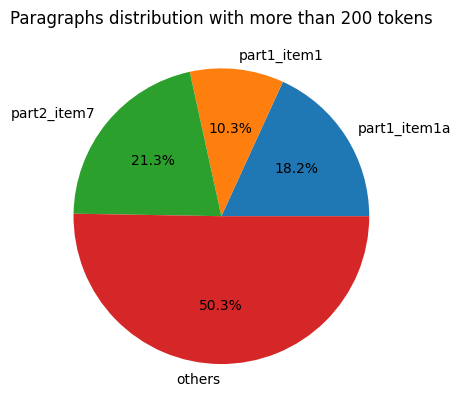

In [12]:
def plot_pie_chart(labels, datas, title):
    # Plot the pie chart
    plt.pie(datas, labels=labels, autopct='%1.1f%%')

    # Add a title
    plt.title(title)

    # Display the plot
    plt.show()

labels = ['part1_item1a', 'part1_item1', 'part2_item7', 'others']
datas = [large_para_group['part1_item1a'], large_para_group['part1_item1'], large_para_group['part2_item7'], sum(large_para_group.values()) - large_para_group['part1_item1a'] - large_para_group['part1_item1'] - large_para_group['part2_item7']]

title = 'Paragraphs distribution with more than 200 tokens'
plot_pie_chart(labels, datas, title)

In [13]:
def retrieve_section(doc_id):
    parts = doc_id.split('_')

    if 'mda' in parts:
        section = parts[parts.index('mda')]
    else:
        # The section is 'partX_itemX'
        section_index = next((i for i, part in enumerate(parts) if part.startswith('part')), None)
        if section_index is not None:
            section = '_'.join(parts[section_index:section_index+2])
        else:
            section = None
    return section

large_para_group = {}
for doc_id, tokens in tokens_per_paragraph.items():
    if tokens >= 200:
        section = retrieve_section(doc_id)
        if section not in large_para_group:
            large_para_group[section] = []
        large_para_group[section].append(doc_id)

In [14]:
large_para_group['part2_item7'][:5]

['20210218_10-K_1705696_part2_item7_para19',
 '20210218_10-K_1705696_part2_item7_para21',
 '20210218_10-K_1705696_part2_item7_para22',
 '20210218_10-K_1705696_part2_item7_para24',
 '20210218_10-K_1705696_part2_item7_para28']